# Business Understanding


## Understanding

- Idea: Implement advanced algorithms to predict stock prices and automate trading decisions.
- Motivation: Outperform traditional trading methods by using data-driven insights to capture market trends and anomalies.
- Solution: Develop models trained on historical data to forecast movements and execute trades efficiently, enhancing profitability and minimizing risks.

## Objection

This project aims to develop a machine learning-based trading bot focused on Tencent stock (0700.HK).

The bot is designed to capitalize on these opportunities by predicting key price movements and executing trades accordingly.

## Why choose Tencent?

The choice of Tencent reflects its significant role in the tech industry and its stock market volatility, which presents numerous trading opportunities.

## Retreive Data

I downloaded the dataset by **yfinance** function,
downloading all dataset online.

I aslo ues **web.DataReader** to download the HKD and USD rate dataset.

## High and Low definition

"high" prices are defined as local maxima, and "low" prices as local minima within a moving **10-day** window.


## Data Overview

The historical stock data for Tencent from **2015 to 2019** will serve as the primary dataset for **training** and **2020** for **validating** our model.

The data for **2021** will be exclusively used to **test** the bot's real-world performance.

## Model

I experiment with several models including **SVM, Random Forest, Lostistics Regression and LSTM.**

Model selection will be based on a combination of performance metrics such as accuracy, precision, recall, and F1-score on Label 1 and 2.

## Trading Strategy


This trading strategy utilizes predictive models to identify optimal buy and sell moments based on market data predictions. It customizes risk thresholds and trade execution strategies according to investor profiles to manage potential gains and losses effectively. The performance of the strategy is continuously monitored and optimized for profitability and risk management.

# Data retrieving and processing

In [1]:
# import packages

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import yfinance as yf

In [2]:
!pip install yfinance

In [3]:
# define a function to download dataset

def download_stock_data(ticker_symbol, start_date, end_date):
    return yf.download(ticker_symbol, start=start_date, end=end_date)

start_date = "2015-01-01"
end_date = "2020-12-31"

In [4]:
# read training dataset

tencent = download_stock_data('0700.HK', start_date, end_date)

print(tencent.shape)
tencent.head()

[*********************100%%**********************]  1 of 1 completed

(1480, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,104.722893,104.722893,102.602623,103.985405,100.762016,11783333
2015-01-05,104.630707,106.290047,103.985405,104.630707,101.387329,23657688
2015-01-06,105.091637,111.083702,104.722893,110.622772,107.193642,47380755
2015-01-07,113.849274,114.771126,113.019600,114.678940,111.124069,44327302
2015-01-08,117.536697,117.813255,115.785172,117.352325,113.714577,38660017


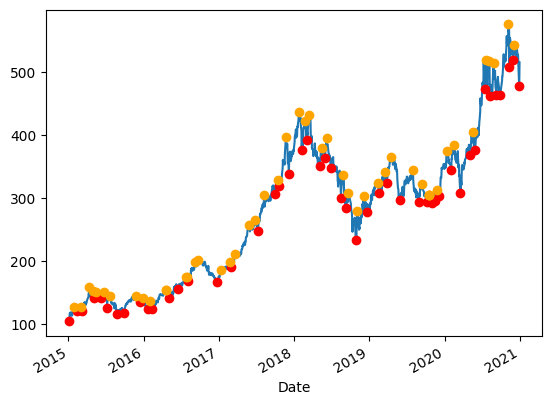

In [5]:
# visualization
# orange for local maximum point
# red for local minimum point

from scipy.signal import argrelextrema
from matplotlib import pyplot as plt

# order is window
order = 10

ax = tencent['Close'].plot()
ax = tencent.iloc[argrelextrema(tencent.Close.values, np.less_equal,
order = order)]['Close'].plot(style="o",color='red')
ax = tencent.iloc[argrelextrema(tencent.Close.values, np.greater_equal,
order = order)]['Close'].plot(style="o",color='orange')
plt.show()

In [6]:
# preprocessing missing value

print(tencent.isna().sum())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


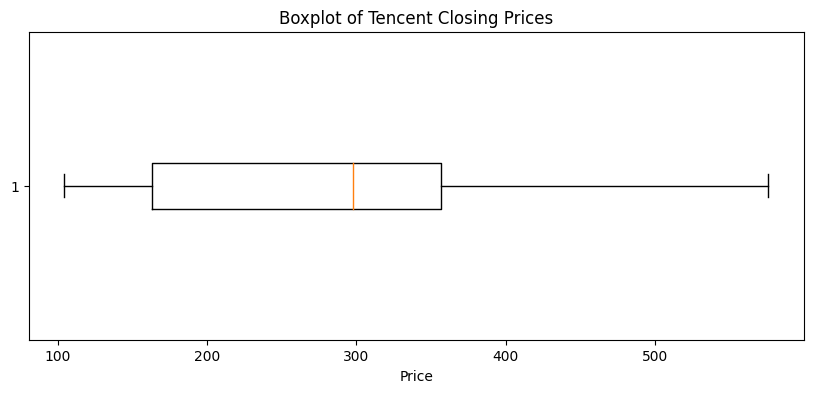

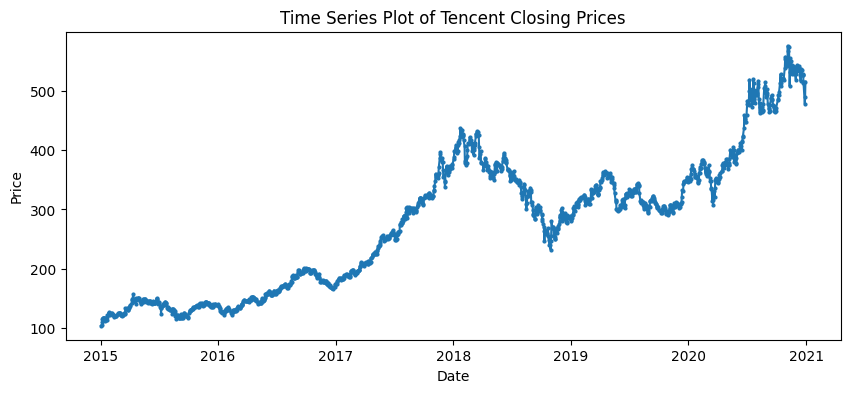

In [7]:
# preprocessing outlier
plt.figure(figsize=(10, 4))
plt.boxplot(tencent['Close'].dropna(), vert=False)
plt.title('Boxplot of Tencent Closing Prices')
plt.xlabel('Price')
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(tencent['Close'], marker='o', linestyle='-', markersize=2)
plt.title('Time Series Plot of Tencent Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [8]:
# nomalization
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
tencent['Z-Close'] = scaler.fit_transform(tencent[['Close']])

tencent.head()

,Open,High,Low,Close,Adj Close,Volume,Z-Close
Date,,,,,,,
2015-01-02,104.722893,104.722893,102.602623,103.985405,100.762016,11783333,0.000000
2015-01-05,104.630707,106.290047,103.985405,104.630707,101.387329,23657688,0.001367
2015-01-06,105.091637,111.083702,104.722893,110.622772,107.193642,47380755,0.014057
2015-01-07,113.849274,114.771126,113.019600,114.678940,111.124069,44327302,0.022647
2015-01-08,117.536697,117.813255,115.785172,117.352325,113.714577,38660017,0.028309


In [9]:
# label construction
# 0 for neither local high nor local low
# 1 for local low
# 2 for local high

tencent['min'] = tencent.iloc[argrelextrema(tencent['Close'].values, np.less_equal, order=order)[0]]['Close']
tencent['max'] = tencent.iloc[argrelextrema(tencent['Close'].values, np.greater_equal, order=order)[0]]['Close']

tencent['Label'] = 0
tencent.loc[tencent['min'].notna(), 'Label'] = 1
tencent.loc[tencent['max'].notna(), 'Label'] = 2
tencent = tencent.drop(['min', 'max'], axis=1)


tencent.head()

,Open,High,Low,Close,Adj Close,Volume,Z-Close,Label
Date,,,,,,,,
2015-01-02,104.722893,104.722893,102.602623,103.985405,100.762016,11783333,0.000000,1
2015-01-05,104.630707,106.290047,103.985405,104.630707,101.387329,23657688,0.001367,0
2015-01-06,105.091637,111.083702,104.722893,110.622772,107.193642,47380755,0.014057,0
2015-01-07,113.849274,114.771126,113.019600,114.678940,111.124069,44327302,0.022647,0
2015-01-08,117.536697,117.813255,115.785172,117.352325,113.714577,38660017,0.028309,0


## What have I done?

1. Download dataset by using **yfinance** function
2. Define the time window as **10** : Focus analysis on short-term trends.
3. Data Processing
- **Missing value** : Ensure data completeness for accurate model training.
- **Outlier** : Prevent model bias and improve predictions.
- **MinMax Standardization** :  Normalize data for equal feature influence.
4. Label construction:  It can more effectively predict critical turning points in stock prices, aiding in decision-making about when to buy or sell shares.
- **Label 0** for neither local high nor local low
- **Label 1** for local low value
- **Label 2** for local high value

# Feature Selection

In [10]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
%cd ..
!rm -R ta-lib ta-lib-0.4.0-src.tar.gz

--2024-04-26 10:26:56--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2024-04-26 10:26:56--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://pilotfiber.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz?viasf=1 [following]
--2024-04-26 10:26:56--  http://pilotfiber.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz?viasf=1
Res

In [11]:
# TA-lib
!pip install TA-Lib

In [12]:
# new column with TA-lib
import talib

tencent['SMA_30'] = talib.SMA(tencent['Close'], timeperiod=30)
tencent['EMA_30'] = talib.EMA(tencent['Close'], timeperiod=30)
tencent['RSI_14'] = talib.RSI(tencent['Close'], timeperiod=14)
tencent['MACD'], tencent['MACD_signal'], tencent['MACD_hist'] = talib.MACD(tencent['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
tencent['upper_band'], tencent['middle_band'], tencent['lower_band'] = talib.BBANDS(tencent['Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)

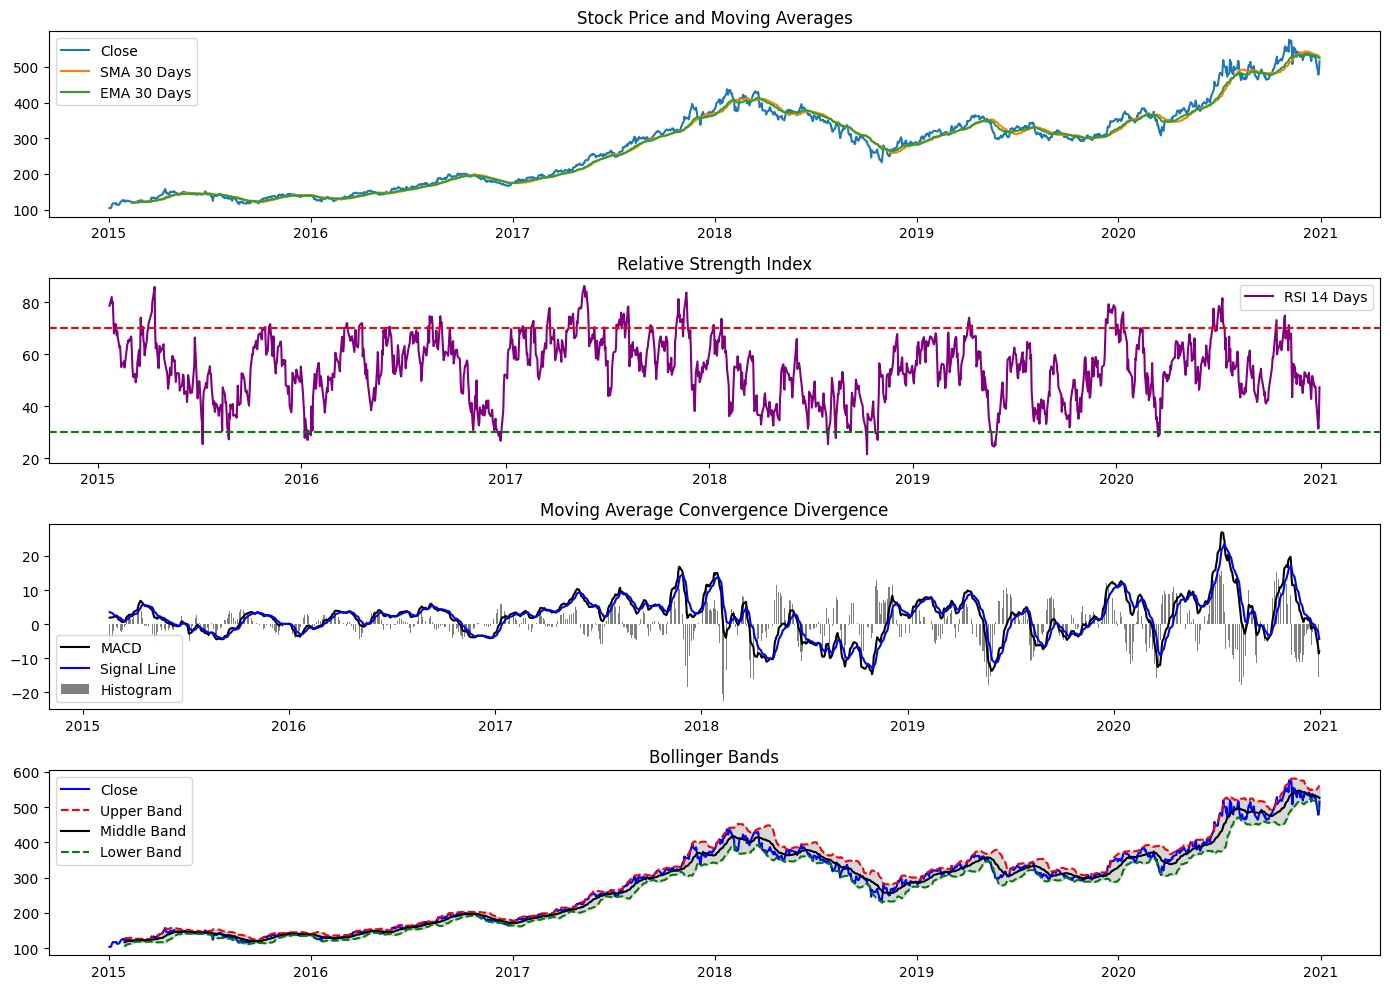

In [13]:
# Visualization

plt.figure(figsize=(14, 10))

plt.subplot(411)
plt.plot(tencent['Close'], label='Close')
plt.plot(tencent['SMA_30'], label='SMA 30 Days')
plt.plot(tencent['EMA_30'], label='EMA 30 Days')
plt.title('Stock Price and Moving Averages')
plt.legend()

plt.subplot(412)
plt.plot(tencent['RSI_14'], label='RSI 14 Days', color='purple')
plt.title('Relative Strength Index')
plt.axhline(70, color='red', linestyle='--')
plt.axhline(30, color='green', linestyle='--')
plt.legend()

plt.subplot(413)
plt.plot(tencent['MACD'], label='MACD', color='black')
plt.plot(tencent['MACD_signal'], label='Signal Line', color='blue')
plt.bar(tencent.index, tencent['MACD_hist'] * 3, label='Histogram', color='gray')
plt.title('Moving Average Convergence Divergence')
plt.legend()

plt.subplot(414)
plt.plot(tencent['Close'], label='Close', color='blue')
plt.plot(tencent['upper_band'], label='Upper Band', linestyle='--', color='red')
plt.plot(tencent['middle_band'], label='Middle Band', linestyle='-', color='black')
plt.plot(tencent['lower_band'], label='Lower Band', linestyle='--', color='green')
plt.fill_between(tencent.index, tencent['upper_band'], tencent['lower_band'], color='grey', alpha=0.3)
plt.title('Bollinger Bands')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
# download related company stock dataset

start_date = "2015-01-01"
end_date = "2020-12-31"

hsi = download_stock_data('^HSI', start_date, end_date)
wangyi = download_stock_data('NTES', start_date, end_date)
HKEX = download_stock_data('0388.HK', start_date, end_date) # Hong Kong Exchanges and Clearing Market
lenovo = download_stock_data('0992.HK', start_date, end_date)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [15]:
# adding into tencent as feature

dfs = [hsi, wangyi, HKEX, lenovo]
names = ['HSI', 'WangYi', 'HKEX', 'Lenovo']

for df, name in zip(dfs, names):
    tencent = tencent.merge(df['Close'].rename(name), on='Date', how='left')

tencent.head()

,Open,High,Low,Close,Adj Close,Volume,Z-Close,Label,SMA_30,EMA_30,...,MACD,MACD_signal,MACD_hist,upper_band,middle_band,lower_band,HSI,WangYi,HKEX,Lenovo
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,104.722893,104.722893,102.602623,103.985405,100.762016,11783333,0.000000,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,23721.300781,19.761999,173.000000,10.22
2015-01-05,104.630707,106.290047,103.985405,104.630707,101.387329,23657688,0.001367,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,23721.320312,19.879999,177.300003,10.06
2015-01-06,105.091637,111.083702,104.722893,110.622772,107.193642,47380755,0.014057,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,23485.410156,20.219999,177.600006,10.08
2015-01-07,113.849274,114.771126,113.019600,114.678940,111.124069,44327302,0.022647,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,23681.259766,20.524000,179.300003,10.42
2015-01-08,117.536697,117.813255,115.785172,117.352325,113.714577,38660017,0.028309,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,23835.529297,20.625999,177.800003,10.84


In [16]:
tencent['Lag_1_day'] = tencent['Close'].shift(1)
tencent['Lag_3_day'] = tencent['Close'].shift(3)
tencent['Lag_7_day'] = tencent['Close'].shift(7)

tencent.head()

,Open,High,Low,Close,Adj Close,Volume,Z-Close,Label,SMA_30,EMA_30,...,upper_band,middle_band,lower_band,HSI,WangYi,HKEX,Lenovo,Lag_1_day,Lag_3_day,Lag_7_day
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,104.722893,104.722893,102.602623,103.985405,100.762016,11783333,0.000000,1,NaN,NaN,...,NaN,NaN,NaN,23721.300781,19.761999,173.000000,10.22,NaN,NaN,NaN
2015-01-05,104.630707,106.290047,103.985405,104.630707,101.387329,23657688,0.001367,0,NaN,NaN,...,NaN,NaN,NaN,23721.320312,19.879999,177.300003,10.06,103.985405,NaN,NaN
2015-01-06,105.091637,111.083702,104.722893,110.622772,107.193642,47380755,0.014057,0,NaN,NaN,...,NaN,NaN,NaN,23485.410156,20.219999,177.600006,10.08,104.630707,NaN,NaN
2015-01-07,113.849274,114.771126,113.019600,114.678940,111.124069,44327302,0.022647,0,NaN,NaN,...,NaN,NaN,NaN,23681.259766,20.524000,179.300003,10.42,110.622772,103.985405,NaN
2015-01-08,117.536697,117.813255,115.785172,117.352325,113.714577,38660017,0.028309,0,NaN,NaN,...,NaN,NaN,NaN,23835.529297,20.625999,177.800003,10.84,114.678940,104.630707,NaN


In [17]:
!pip install pandas_datareader

In [18]:
import pandas_datareader.data as web
import datetime

start = datetime.datetime(2015, 1, 1)
end = datetime.datetime(2020, 12, 31)

hk_usd_exchange_rate = web.DataReader('DEXHKUS', 'fred', start, end)
hk_usd_exchange_rate

,DEXHKUS
DATE,
2015-01-01,NaN
2015-01-02,7.7563
2015-01-05,7.7557
2015-01-06,7.7532
2015-01-07,7.7548
...,...
2020-12-25,NaN
2020-12-28,7.7536
2020-12-29,7.7539


In [19]:
tencent = pd.merge(tencent, hk_usd_exchange_rate, left_index=True, right_index=True, how='outer')
tencent

,Open,High,Low,Close,Adj Close,Volume,Z-Close,Label,SMA_30,EMA_30,...,middle_band,lower_band,HSI,WangYi,HKEX,Lenovo,Lag_1_day,Lag_3_day,Lag_7_day,DEXHKUS
2015-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,104.722893,104.722893,102.602623,103.985405,100.762016,11783333.0,0.000000,1.0,NaN,NaN,...,NaN,NaN,23721.300781,19.761999,173.000000,10.22,NaN,NaN,NaN,7.7563
2015-01-05,104.630707,106.290047,103.985405,104.630707,101.387329,23657688.0,0.001367,0.0,NaN,NaN,...,NaN,NaN,23721.320312,19.879999,177.300003,10.06,103.985405,NaN,NaN,7.7557
2015-01-06,105.091637,111.083702,104.722893,110.622772,107.193642,47380755.0,0.014057,0.0,NaN,NaN,...,NaN,NaN,23485.410156,20.219999,177.600006,10.08,104.630707,NaN,NaN,7.7532
2015-01-07,113.849274,114.771126,113.019600,114.678940,111.124069,44327302.0,0.022647,0.0,NaN,NaN,...,NaN,NaN,23681.259766,20.524000,179.300003,10.42,110.622772,103.985405,NaN,7.7548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-28,497.341553,499.646210,478.443512,478.443512,471.328674,65693227.0,0.793050,1.0,531.849714,527.509832,...,528.569441,500.277505,26314.630859,91.129997,414.200012,7.23,513.934998,527.762817,526.840942,7.7536
2020-12-29,488.583923,496.880615,484.896484,489.044861,481.772369,39322878.0,0.815502,0.0,529.806265,525.028221,...,527.071425,494.122966,26568.490234,93.440002,413.200012,7.20,478.443512,526.380005,537.442322,7.7539
2020-12-30,499.646210,519.005188,496.880615,515.778687,508.108643,31656728.0,0.872120,0.0,529.130238,524.431477,...,526.218709,493.028974,27147.109375,95.930000,425.200012,7.15,489.044861,513.934998,534.676758,7.7521


## Final Data Processing

In [20]:
print(tencent.isna().sum())

Open            86
High            86
Low             86
Close           86
Adj Close       86
Volume          86
Z-Close         86
Label           86
SMA_30         115
EMA_30         115
RSI_14         100
MACD           119
MACD_signal    119
MACD_hist      119
upper_band     105
middle_band    105
lower_band     105
HSI             89
WangYi         121
HKEX            86
Lenovo          86
Lag_1_day       87
Lag_3_day       89
Lag_7_day       93
DEXHKUS         67
dtype: int64


1. From 'Open' to 'Label' we have 86 missing values, which means on vacation or weekend. This is normal missing value.
2. From 'SMA_30' to 'lower_band' we have more than 86 normal missing values, which means, for instance, a 30-day SMA cannot generate its first data point until there are at least 30 days of data available.
3. 'HSI' and 'WangYi' have more than 86 missing values, it maybe have different vacation calender with Tencent.
4. From 'Lag_1_day' to 'Lag_7_day' have more than 86 missing values, which means we laged the specific date.
5. DEXHKUS has less than 86 missing values, which is good.


We can fill them all with 'back fill' then 'forward fill' to fill the last missing value

In [21]:
tencent.fillna(method='bfill', inplace=True)

tencent.fillna(method='ffill', inplace=True)

In [22]:
tencent

,Open,High,Low,Close,Adj Close,Volume,Z-Close,Label,SMA_30,EMA_30,...,middle_band,lower_band,HSI,WangYi,HKEX,Lenovo,Lag_1_day,Lag_3_day,Lag_7_day,DEXHKUS
2015-01-01,104.722893,104.722893,102.602623,103.985405,100.762016,11783333.0,0.000000,1.0,118.996303,118.996303,...,117.052722,104.787127,23721.300781,19.761999,173.000000,10.22,103.985405,103.985405,103.985405,7.7563
2015-01-02,104.722893,104.722893,102.602623,103.985405,100.762016,11783333.0,0.000000,1.0,118.996303,118.996303,...,117.052722,104.787127,23721.300781,19.761999,173.000000,10.22,103.985405,103.985405,103.985405,7.7563
2015-01-05,104.630707,106.290047,103.985405,104.630707,101.387329,23657688.0,0.001367,0.0,118.996303,118.996303,...,117.052722,104.787127,23721.320312,19.879999,177.300003,10.06,103.985405,103.985405,103.985405,7.7557
2015-01-06,105.091637,111.083702,104.722893,110.622772,107.193642,47380755.0,0.014057,0.0,118.996303,118.996303,...,117.052722,104.787127,23485.410156,20.219999,177.600006,10.08,104.630707,103.985405,103.985405,7.7532
2015-01-07,113.849274,114.771126,113.019600,114.678940,111.124069,44327302.0,0.022647,0.0,118.996303,118.996303,...,117.052722,104.787127,23681.259766,20.524000,179.300003,10.42,110.622772,103.985405,103.985405,7.7548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-25,497.341553,499.646210,478.443512,478.443512,471.328674,65693227.0,0.793050,1.0,531.849714,527.509832,...,528.569441,500.277505,26314.630859,91.129997,414.200012,7.23,513.934998,527.762817,526.840942,7.7536
2020-12-28,497.341553,499.646210,478.443512,478.443512,471.328674,65693227.0,0.793050,1.0,531.849714,527.509832,...,528.569441,500.277505,26314.630859,91.129997,414.200012,7.23,513.934998,527.762817,526.840942,7.7536
2020-12-29,488.583923,496.880615,484.896484,489.044861,481.772369,39322878.0,0.815502,0.0,529.806265,525.028221,...,527.071425,494.122966,26568.490234,93.440002,413.200012,7.20,478.443512,526.380005,537.442322,7.7539
2020-12-30,499.646210,519.005188,496.880615,515.778687,508.108643,31656728.0,0.872120,0.0,529.130238,524.431477,...,526.218709,493.028974,27147.109375,95.930000,425.200012,7.15,489.044861,513.934998,534.676758,7.7521


## What have I done?

1. Adding features by using **TA-lib**, and the features are :
- **SMA and EMA (30 days)**: Capture trends over the past month.
- **RSI (14 days)**: Indicate overbought or oversold conditions.
- **MACD**: Identify changes in momentum.
- **Bollinger Band**: Provide insights on price volatility.
2. Downloading stock dataset like Tencent as the feature: Broaden market perspective by incorporating data from various influential stocks in the Hong Kong market.
- **'Hang Seng Bank'**
- **'Wang Yi'**
- **'HKEX'**
- **'Lenovo'**
3. Price movements of previous dates as features, which is **1, 3, 7** days: Utilize short-term historical data to capture recent price dynamics and trends.
4. Downloading the **HKD and USD rate** as feature: Include economic indicators that impact international trading and investment decisions.
5. Final data processing: Ensure the model is trained on accurate, reliable, and normalized data to improve prediction accuracy.


# Modelling and Evaluation


In [23]:
train_data = tencent['2015-01-01':'2019-12-31']
validation_data = tencent['2020-01-01':'2020-12-31']

X_train = train_data.drop('Label', axis=1)
y_train = train_data['Label']
X_validation = validation_data.drop('Label', axis=1)
y_validation = validation_data['Label']

print("Training samples:", len(train_data))
print("Validation samples:", len(validation_data))
print("Number of features:", len(X_train.columns))
print("Positive samples in training:", (y_train == 2).sum())
print("Negative samples in training:", (y_train == 1).sum())

Training samples: 1304
Validation samples: 262
Number of features: 24
Positive samples in training: 42
Negative samples in training: 39


Logistic Regression - Accuracy: 0.92, F1 Score: 0.32


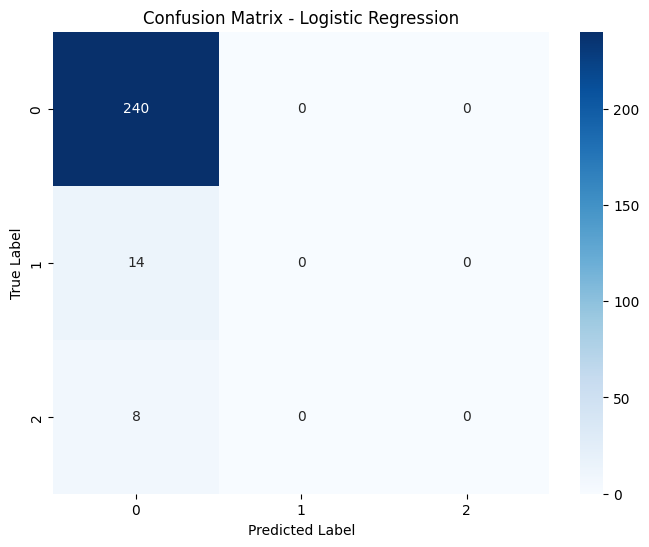

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report - Logistic Regression:
              precision    recall  f1-score   support

     Class 0       0.92      1.00      0.96       240
     Class 1       0.00      0.00      0.00        14
     Class 2       0.00      0.00      0.00         8

    accuracy                           0.92       262
   macro avg       0.31      0.33      0.32       262
weighted avg       0.84      0.92      0.88       262

Random Forest - Accuracy: 0.48, F1 Score: 0.24


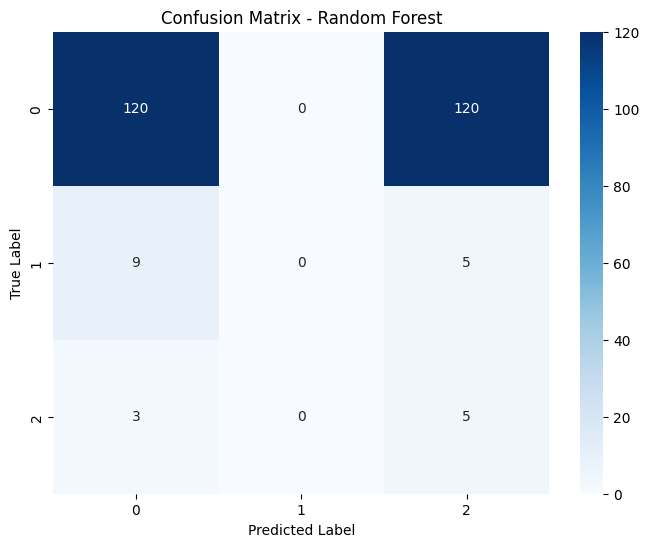

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report - Random Forest:
              precision    recall  f1-score   support

     Class 0       0.91      0.50      0.65       240
     Class 1       0.00      0.00      0.00        14
     Class 2       0.04      0.62      0.07         8

    accuracy                           0.48       262
   macro avg       0.32      0.38      0.24       262
weighted avg       0.83      0.48      0.59       262

SVM - Accuracy: 0.92, F1 Score: 0.32


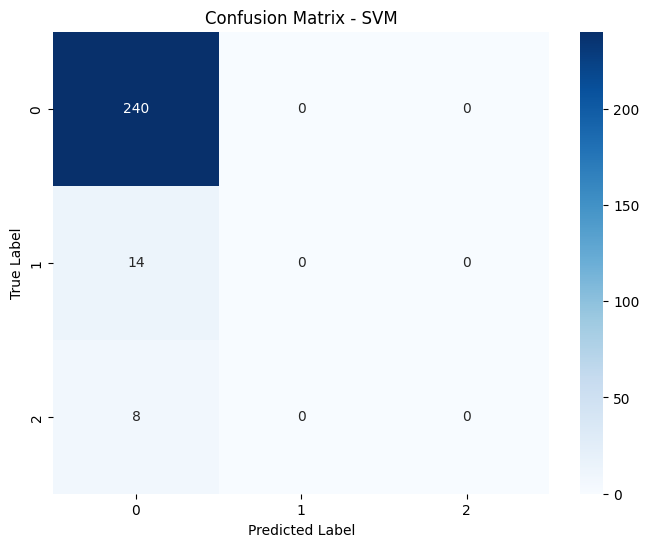

Classification Report - SVM:
              precision    recall  f1-score   support

     Class 0       0.92      1.00      0.96       240
     Class 1       0.00      0.00      0.00        14
     Class 2       0.00      0.00      0.00         8

    accuracy                           0.92       262
   macro avg       0.31      0.33      0.32       262
weighted avg       0.84      0.92      0.88       262



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM": SVC()
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_validation)
    accuracy = accuracy_score(y_validation, y_pred)
    f1 = f1_score(y_validation, y_pred, average='macro')
    results[name] = (accuracy, f1)
    print(f"{name} - Accuracy: {accuracy:.2f}, F1 Score: {f1:.2f}")

    cm = confusion_matrix(y_validation, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    report = classification_report(y_validation, y_pred, target_names=['Class 0', 'Class 1', 'Class 2'])
    print(f"Classification Report - {name}:\n{report}")

Logistic Regression - Accuracy: 0.06, F1 Score: 0.09


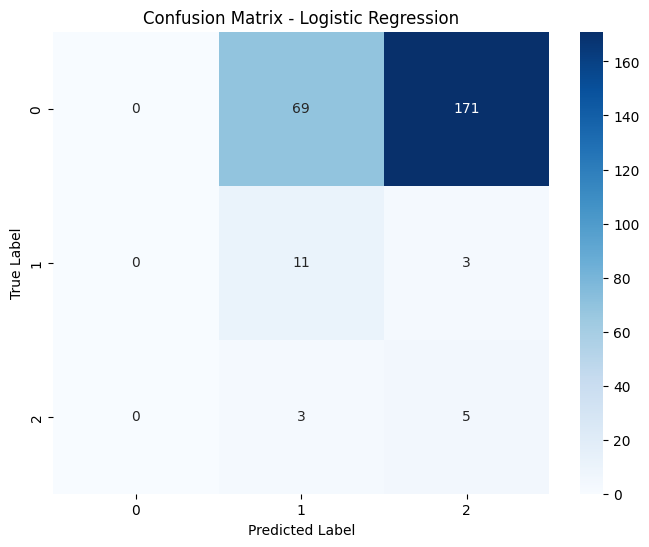

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report - Logistic Regression:
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00       240
     Class 1       0.13      0.79      0.23        14
     Class 2       0.03      0.62      0.05         8

    accuracy                           0.06       262
   macro avg       0.05      0.47      0.09       262
weighted avg       0.01      0.06      0.01       262

Random Forest - Accuracy: 0.92, F1 Score: 0.32


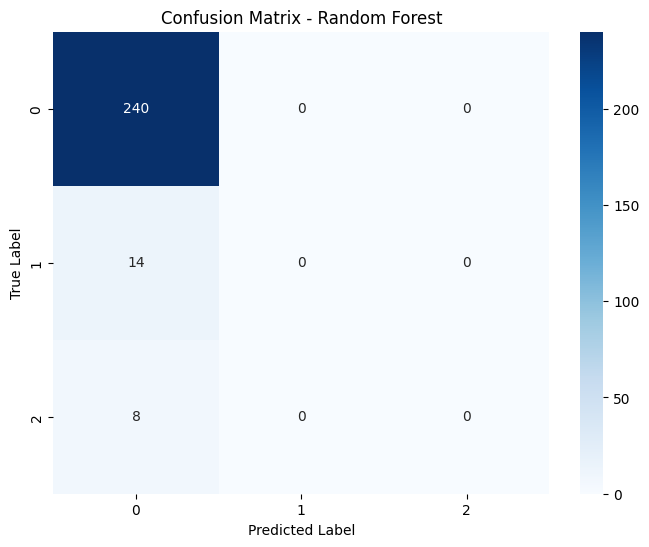

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report - Random Forest:
              precision    recall  f1-score   support

     Class 0       0.92      1.00      0.96       240
     Class 1       0.00      0.00      0.00        14
     Class 2       0.00      0.00      0.00         8

    accuracy                           0.92       262
   macro avg       0.31      0.33      0.32       262
weighted avg       0.84      0.92      0.88       262

SVM - Accuracy: 0.40, F1 Score: 0.23


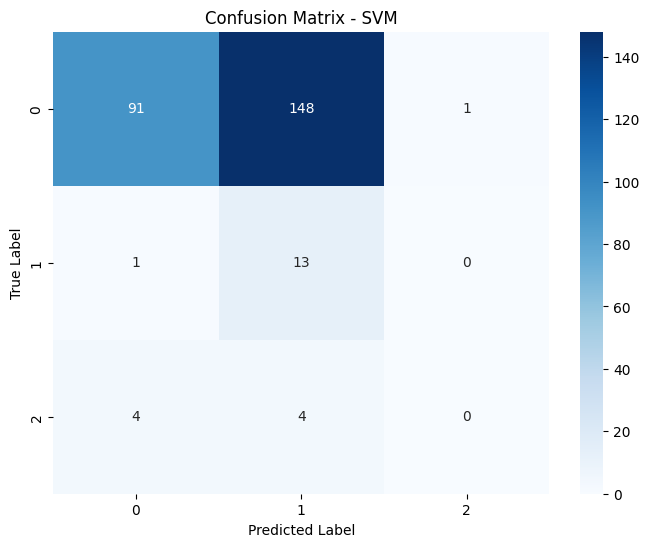

Classification Report - SVM:
              precision    recall  f1-score   support

     Class 0       0.95      0.38      0.54       240
     Class 1       0.08      0.93      0.15        14
     Class 2       0.00      0.00      0.00         8

    accuracy                           0.40       262
   macro avg       0.34      0.44      0.23       262
weighted avg       0.87      0.40      0.50       262



In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report

models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced'),
    "SVM": SVC(class_weight='balanced')
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_validation)
    accuracy = accuracy_score(y_validation, y_pred)
    f1 = f1_score(y_validation, y_pred, average='macro')
    results[name] = (accuracy, f1)
    print(f"{name} - Accuracy: {accuracy:.2f}, F1 Score: {f1:.2f}")

    cm = confusion_matrix(y_validation, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    report = classification_report(y_validation, y_pred, target_names=['Class 0', 'Class 1', 'Class 2'])
    print(f"Classification Report - {name}:\n{report}")

In [26]:
!pip install tensorflow

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.utils import to_categorical

y_train_categorical = to_categorical(y_train, num_classes=3)
y_validation_categorical = to_categorical(y_validation, num_classes=3)

def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

n_steps = 1
n_features = X_train.shape[1]
X_train_reshaped = X_train.values.reshape((X_train.shape[0], n_steps, n_features))
X_validation_reshaped = X_validation.values.reshape((X_validation.shape[0], n_steps, n_features))

model = build_model((n_steps, n_features))
history = model.fit(X_train_reshaped, y_train_categorical, epochs=20, batch_size=32, validation_data=(X_validation_reshaped, y_validation_categorical), verbose=1)

y_pred_proba = model.predict(X_validation_reshaped)
y_pred = np.argmax(y_pred_proba, axis=1)
accuracy = accuracy_score(y_validation, y_pred)
f1 = f1_score(y_validation, y_pred, average='macro')
print(f"LSTM - Accuracy: {accuracy:.2f}, F1 Score: {f1:.2f}")

Epoch 1/20
41/41 [==============================] - 9s 58ms/step - loss: 0.7867 - accuracy: 0.7914 - val_loss: 0.4635 - val_accuracy: 0.9160
Epoch 2/20
41/41 [==============================] - 1s 13ms/step - loss: 0.3249 - accuracy: 0.9379 - val_loss: 0.3550 - val_accuracy: 0.9160
Epoch 3/20
41/41 [==============================] - 1s 14ms/step - loss: 0.2845 - accuracy: 0.9379 - val_loss: 0.3576 - val_accuracy: 0.9160
Epoch 4/20
41/41 [==============================] - 1s 17ms/step - loss: 0.2898 - accuracy: 0.9379 - val_loss: 0.3564 - val_accuracy: 0.9160
Epoch 5/20
41/41 [==============================] - 1s 14ms/step - loss: 0.2862 - accuracy: 0.9379 - val_loss: 0.3552 - val_accuracy: 0.9160
Epoch 6/20
41/41 [==============================] - 1s 18ms/step - loss: 0.2858 - accuracy: 0.9379 - val_loss: 0.3567 - val_accuracy: 0.9160
Epoch 7/20
41/41 [==============================] - 0s 11ms/step - loss: 0.2855 - accuracy: 0.9379 - val_loss: 0.3535 - val_accuracy: 0.9160
Epoch 8/20
41

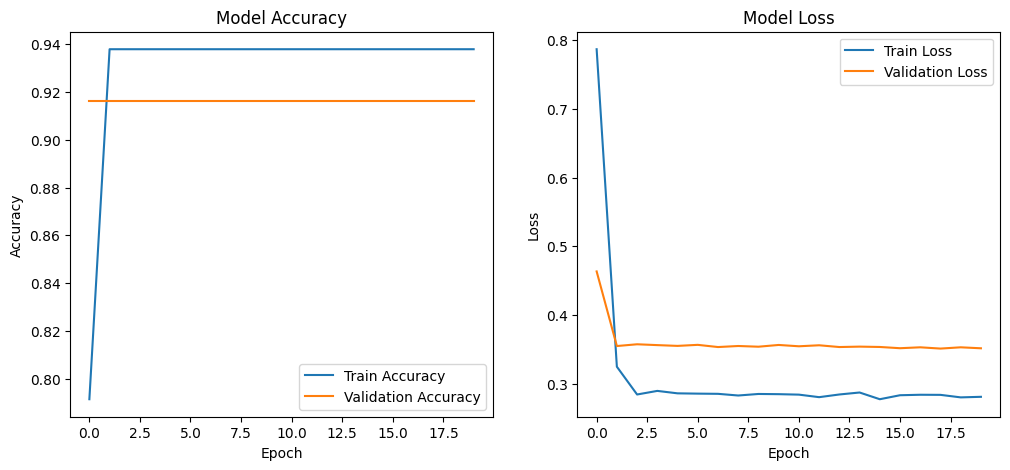

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


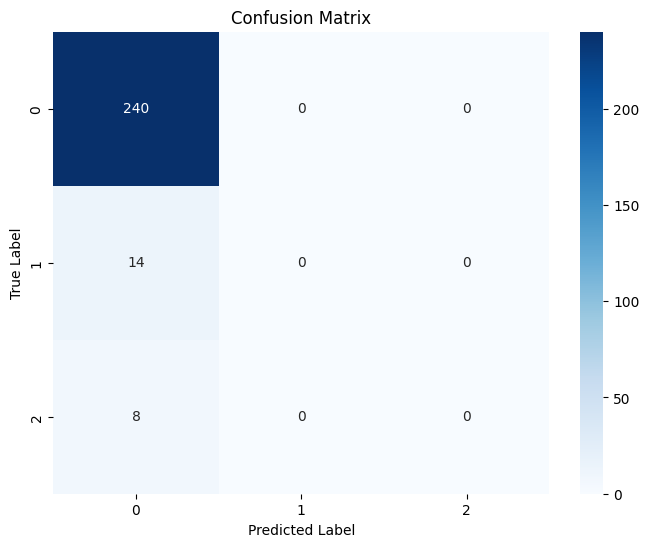

In [29]:
import seaborn as sns

cm = confusion_matrix(y_validation, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [30]:
from sklearn.metrics import classification_report

report = classification_report(y_validation, y_pred, target_names=['0', '1', '2'])
print(report)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       240
           1       0.00      0.00      0.00        14
           2       0.00      0.00      0.00         8

    accuracy                           0.92       262
   macro avg       0.31      0.33      0.32       262
weighted avg       0.84      0.92      0.88       262



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Understanding

In the initial phase of our stock prediction project, we applied three traditional machine learning models: Logistic Regression, Support Vector Machine (SVM), and Random Forest. Despite achieving high accuracy scores, we encountered a significant issue. The models predominantly predicted the majority class, disregarding the minority classes (labeled as '1' and '2'), which are critical in our context. This skewed result was due to the class imbalance within our dataset, where the occurrences of '1' and '2' were relatively rare compared to the '0' class.

To address this imbalance, we made our first crucial adjustment by setting the **class_weight** parameter to '**balanced**' for them. This change prompted the models to assign a higher penalty to misclassifications of the minority classes, thereby improving their predictive performance for the classes '1' and '2'.

Subsequently, we introduced LSTM network to our suite of models, hoping to leverage its capability in capturing temporal dependencies. However, much like our initial approach with the machine learning models, the LSTM's predictions were heavily biased towards the majority class, outputting a constant '0' for all predictions.

## What have I done?

1. **Dataset Splitting Strategy**: I want to train more and get a better model, so just 1 year for validation.
- **Training Period**: 2015-2019
- **Validation Period**: 2020
2. The **model** I used:
- **SVM**: good prediction in Label 1
- **Random Forest**: perform not very well here
- **Logistic Regression**: good predition in Label 1 and 2
- **LSTM**: A type of recurrent neural network capable of learning order dependence in sequence prediction problems, especially useful for time-series data. **Fail** in imbalanced dataset.
3. **Report** the dataset statistics
- Label '1': Negative
- Label '2': Positive
- Training samples: 1304
- Validation samples: 262
- Number of features: 24
- Positive samples in training: 42
- Negative samples in training: 39

#  Real business performance delivery

## Model

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

train_data = tencent['2015-01-01':'2020-12-31']

X_train = train_data.drop('Label', axis=1)
y_train = train_data['Label']

In [32]:
lr_model = LogisticRegression(class_weight='balanced')

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

grid_search = GridSearchCV(lr_model, param_grid, cv=5, scoring='accuracy', verbose=1)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
best_lr_model = grid_search.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

Best parameters: {'C': 0.01, 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [33]:
n_steps = 1
n_features = X_train.shape[1]
X_train_reshaped = X_train.values.reshape((X_train.shape[0], n_steps, n_features))
y_train_categorical = to_categorical(y_train, num_classes=3)

lstm = build_model((n_steps, n_features))
lstm.fit(X_train_reshaped, y_train_categorical, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
49/49 [==============================] - 12s 13ms/step - loss: 0.5654 - accuracy: 0.9317
Epoch 2/20
49/49 [==============================] - 1s 11ms/step - loss: 0.2991 - accuracy: 0.9336
Epoch 3/20
49/49 [==============================] - 0s 10ms/step - loss: 0.3011 - accuracy: 0.9342
Epoch 4/20
49/49 [==============================] - 0s 8ms/step - loss: 0.2982 - accuracy: 0.9342
Epoch 5/20
49/49 [==============================] - 1s 10ms/step - loss: 0.2933 - accuracy: 0.9342
Epoch 6/20
49/49 [==============================] - 0s 9ms/step - loss: 0.3004 - accuracy: 0.9342
Epoch 7/20
49/49 [==============================] - 0s 9ms/step - loss: 0.2964 - accuracy: 0.9342
Epoch 8/20
49/49 [==============================] - 0s 9ms/step - loss: 0.3003 - accuracy: 0.9342
Epoch 9/20
49/49 [==============================] - 0s 10ms/step - loss: 0.2916 - accuracy: 0.9342
Epoch 10/20
49/49 [==============================] - 0s 9ms/step - loss: 0.2934 - accuracy: 0.9342
Epoch 11/20
4

## Data

In [34]:
# read testing dataset

ticker_symbol = "0700.HK"
start_date = '2021-01-01'
end_date = '2021-12-31'

tencent_2021 = yf.download(ticker_symbol, start=start_date, end=end_date)

print(tencent_2021.shape)
tencent_2021.head()

[*********************100%%**********************]  1 of 1 completed

(246, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,514.395874,537.442322,513.934998,527.762817,519.914490,22545919
2021-01-05,527.301880,540.668823,521.309814,537.903259,529.904236,20250507
2021-01-06,539.286011,552.192017,539.286011,549.887390,541.710144,27892115
2021-01-07,535.137695,538.825073,524.075378,524.075378,516.281921,43257974
2021-01-08,524.075378,532.833008,523.153564,528.223755,520.368652,24801900


In [35]:
scaler = MinMaxScaler()
tencent_2021['Z-Close'] = scaler.fit_transform(tencent_2021[['Close']])

tencent_2021['min'] = tencent_2021.iloc[argrelextrema(tencent_2021['Close'].values, np.less_equal, order=order)[0]]['Close']
tencent_2021['max'] = tencent_2021.iloc[argrelextrema(tencent_2021['Close'].values, np.greater_equal, order=order)[0]]['Close']

tencent_2021['Label'] = 0
tencent_2021.loc[tencent_2021['min'].notna(), 'Label'] = 1
tencent_2021.loc[tencent_2021['max'].notna(), 'Label'] = 2
tencent_2021 = tencent_2021.drop(['min', 'max'], axis=1)

tencent_2021['SMA_30'] = talib.SMA(tencent_2021['Close'], timeperiod=30)
tencent_2021['EMA_30'] = talib.EMA(tencent_2021['Close'], timeperiod=30)
tencent_2021['RSI_14'] = talib.RSI(tencent_2021['Close'], timeperiod=14)
tencent_2021['MACD'], tencent_2021['MACD_signal'], tencent_2021['MACD_hist'] = talib.MACD(tencent_2021['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
tencent_2021['upper_band'], tencent_2021['middle_band'], tencent_2021['lower_band'] = talib.BBANDS(tencent_2021['Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)

hsi = download_stock_data('^HSI', start_date, end_date)
wangyi = download_stock_data('NTES', start_date, end_date)
HKEX = download_stock_data('0388.HK', start_date, end_date)
lenovo = download_stock_data('0992.HK', start_date, end_date)
dfs = [hsi, wangyi, HKEX, lenovo]
names = ['HSI', 'WangYi', 'HKEX', 'Lenovo']
for df, name in zip(dfs, names):
    tencent_2021 = tencent_2021.merge(df['Close'].rename(name), on='Date', how='left')

tencent_2021['Lag_1_day'] = tencent_2021['Close'].shift(1)
tencent_2021['Lag_3_day'] = tencent_2021['Close'].shift(3)
tencent_2021['Lag_7_day'] = tencent_2021['Close'].shift(7)

start = datetime.datetime(2021, 1, 1)
end = datetime.datetime(2021, 12, 31)
hk_usd_exchange_rate = web.DataReader('DEXHKUS', 'fred', start, end)
tencent_2021 = pd.merge(tencent_2021, hk_usd_exchange_rate, left_index=True, right_index=True, how='outer')

tencent_2021.fillna(method='bfill', inplace=True)
tencent_2021.fillna(method='ffill', inplace=True)

tencent_2021

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Z-Close,Label,SMA_30,EMA_30,...,middle_band,lower_band,HSI,WangYi,HKEX,Lenovo,Lag_1_day,Lag_3_day,Lag_7_day,DEXHKUS
2021-01-01,514.395874,537.442322,513.934998,527.762817,519.914490,22545919.0,0.438170,0.0,621.961186,621.961186,...,592.730655,490.185789,27472.810547,96.739998,441.799988,7.62,527.762817,527.762817,527.762817,7.7537
2021-01-04,514.395874,537.442322,513.934998,527.762817,519.914490,22545919.0,0.438170,0.0,621.961186,621.961186,...,592.730655,490.185789,27472.810547,96.739998,441.799988,7.62,527.762817,527.762817,527.762817,7.7537
2021-01-05,527.301880,540.668823,521.309814,537.903259,529.904236,20250507.0,0.470026,0.0,621.961186,621.961186,...,592.730655,490.185789,27649.859375,101.570000,457.000000,7.63,527.762817,527.762817,527.762817,7.7533
2021-01-06,539.286011,552.192017,539.286011,549.887390,541.710144,27892115.0,0.507675,0.0,621.961186,621.961186,...,592.730655,490.185789,27692.300781,103.610001,449.000000,7.48,537.903259,527.762817,527.762817,7.7532
2021-01-07,535.137695,538.825073,524.075378,524.075378,516.281921,43257974.0,0.426586,1.0,621.961186,621.961186,...,592.730655,490.185789,27548.519531,111.889999,443.000000,7.56,549.887390,527.762817,527.762817,7.7534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,422.025879,423.316467,410.226105,415.204132,410.239594,20555921.0,0.084564,0.0,430.006085,425.588142,...,421.196210,399.722699,23280.560547,97.150002,455.399994,9.01,424.238342,408.382416,417.232239,7.8000
2021-12-28,422.025879,423.316467,410.226105,415.204132,410.239594,20555921.0,0.084564,0.0,430.006085,425.588142,...,421.196210,399.722699,23280.560547,97.150002,455.399994,9.01,424.238342,408.382416,417.232239,7.7990
2021-12-29,408.935516,410.779236,405.985565,410.041748,405.138947,10402269.0,0.068346,0.0,428.233047,424.585148,...,420.523254,398.543210,23086.539062,95.250000,453.600006,8.99,415.204132,425.713318,403.773132,7.7968
2021-12-30,411.516724,415.572876,407.460541,408.751160,403.863800,8314363.0,0.064292,0.0,426.217255,423.563601,...,419.352498,397.483707,23112.009766,103.750000,454.200012,8.81,410.041748,424.238342,396.398285,7.7996


## Outcome

In [36]:
X_test = tencent_2021.drop('Label', axis=1)
y_test = tencent_2021['Label']

scaler = MinMaxScaler()

X_test_scaled = scaler.fit_transform(X_test)

lr_predictions = best_lr_model.predict(X_test_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [37]:
lr_df = pd.DataFrame(lr_predictions, columns=['LR_Prediction'], index=tencent_2021.index)

tencent_2021 = pd.concat([tencent_2021, lr_df], axis=1)

tencent_2021

,Open,High,Low,Close,Adj Close,Volume,Z-Close,Label,SMA_30,EMA_30,...,lower_band,HSI,WangYi,HKEX,Lenovo,Lag_1_day,Lag_3_day,Lag_7_day,DEXHKUS,LR_Prediction
2021-01-01,514.395874,537.442322,513.934998,527.762817,519.914490,22545919.0,0.438170,0.0,621.961186,621.961186,...,490.185789,27472.810547,96.739998,441.799988,7.62,527.762817,527.762817,527.762817,7.7537,1.0
2021-01-04,514.395874,537.442322,513.934998,527.762817,519.914490,22545919.0,0.438170,0.0,621.961186,621.961186,...,490.185789,27472.810547,96.739998,441.799988,7.62,527.762817,527.762817,527.762817,7.7537,1.0
2021-01-05,527.301880,540.668823,521.309814,537.903259,529.904236,20250507.0,0.470026,0.0,621.961186,621.961186,...,490.185789,27649.859375,101.570000,457.000000,7.63,527.762817,527.762817,527.762817,7.7533,1.0
2021-01-06,539.286011,552.192017,539.286011,549.887390,541.710144,27892115.0,0.507675,0.0,621.961186,621.961186,...,490.185789,27692.300781,103.610001,449.000000,7.48,537.903259,527.762817,527.762817,7.7532,1.0
2021-01-07,535.137695,538.825073,524.075378,524.075378,516.281921,43257974.0,0.426586,1.0,621.961186,621.961186,...,490.185789,27548.519531,111.889999,443.000000,7.56,549.887390,527.762817,527.762817,7.7534,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,422.025879,423.316467,410.226105,415.204132,410.239594,20555921.0,0.084564,0.0,430.006085,425.588142,...,399.722699,23280.560547,97.150002,455.399994,9.01,424.238342,408.382416,417.232239,7.8000,0.0
2021-12-28,422.025879,423.316467,410.226105,415.204132,410.239594,20555921.0,0.084564,0.0,430.006085,425.588142,...,399.722699,23280.560547,97.150002,455.399994,9.01,424.238342,408.382416,417.232239,7.7990,0.0
2021-12-29,408.935516,410.779236,405.985565,410.041748,405.138947,10402269.0,0.068346,0.0,428.233047,424.585148,...,398.543210,23086.539062,95.250000,453.600006,8.99,415.204132,425.713318,403.773132,7.7968,0.0
2021-12-30,411.516724,415.572876,407.460541,408.751160,403.863800,8314363.0,0.064292,0.0,426.217255,423.563601,...,397.483707,23112.009766,103.750000,454.200012,8.81,410.041748,424.238342,396.398285,7.7996,0.0


In [38]:
def get_predicted_low_dates(data):
    predicted_low_dates = data[data['LR_Prediction'] == 1].index.tolist()
    return predicted_low_dates

def get_stock_prices(data):
    stock_prices = data['Close'].to_dict()
    return stock_prices

In [39]:
import random

def trading_strategy(predicted_low_dates, stock_prices, g, l, d, investor_type='random'):
    holding = False
    buy_price = 0
    holding_days = 0
    balance = 0
    shares = 0

    for date in predicted_low_dates:
        if investor_type == 'random':
            if random.choice([True, False]):
                if not holding:
                    if date in stock_prices:
                        buy_price = stock_prices[date]
                        shares = 100
                        balance -= buy_price * 100
                        holding = True
                        holding_days = 0
                else:
                    if date in stock_prices:
                        current_price = stock_prices[date]
                        balance += current_price * shares
                        holding = False
                        shares = 0
                        buy_price = 0
        else:
            if not holding and date in stock_prices:
                buy_price = stock_prices[date]
                shares = 100
                balance -= buy_price * 100
                holding = True
                holding_days = 0

            elif holding:
                current_price = stock_prices.get(date, None)
                if current_price:
                    profit_percent = (current_price - buy_price) / buy_price * 100

                    if profit_percent >= g or profit_percent <= -l or holding_days >= d:
                        balance += current_price * shares
                        holding = False
                        buy_price = 0
                        shares = 0
                        holding_days = 0
                    else:
                        holding_days += 1

    return balance

predicted_low_dates = get_predicted_low_dates(tencent_2021)
stock_prices = get_stock_prices(tencent_2021)

In [53]:
investor_types = {
    "Short-term Investor": (2, -2, 5),
    "Medium-term Investor": (5, -5, 12),
    "Long-term Holder": (10, -10, 25),
    "The Random Investor": (0, 0, 0)
}

results = {}
for investor, params in investor_types.items():
    if investor == "The Random Investor":
        profit = trading_strategy(predicted_low_dates, stock_prices, *params, investor_type='random')
    else:
        profit = trading_strategy(predicted_low_dates, stock_prices, *params)
    results[investor] = profit
    print(f"{investor} profit: {profit}")

Short-term Investor profit: -46240.33203125
Medium-term Investor profit: 16869.9462890625
Long-term Holder profit: 4083.7982177734375
The Random Investor profit: -7937.1978759765625


## Outcome Understanding

**Short-term Investo**r: This strategy resulted in a significant loss (-46,240.33) compared to the Random Investor (-$7,937.20). This suggests that the aggressive trading tactics aimed at quick gains might be too risky or poorly timed, leading to substantial losses.


**Medium-term Investor**: With a profit of $16,869.95, this strategy significantly outperformed the Random Investor's result. This indicates that a balanced approach with moderate holding periods and risk thresholds aligns better with market conditions, capturing profitable opportunities more effectively.


**Long-term Holder**: Although the profit ($4,083.80) is modest, it still surpasses the Random Investor's performance. This suggests that a conservative strategy focusing on longer-term gains can provide stability and positive returns, albeit smaller than more actively managed approaches.

## Strategy

1. **Short-term Investor**: `(2, -2, 5)`
- **Gain (2%)**: Targets quick, small profits.
- **Loss (-2%)**: Implements a tight stop-loss to minimize losses.
- **Duration (5 days)**: Prefers a brief holding period to reduce exposure to market volatility.

2. **Medium-term Investor**: `(5, -5, 12)`
- **Gain (5%)**: Seeks moderate gains, allowing stocks more time to appreciate.
- **Loss (-5%)**: Tolerates larger dips, giving stocks room to recover.
- **Duration (12 days)**: Balances between frequent trading and long-term holding.

3. **Long-term Holder**: `(10, -10, 25)`
- **Gain (10%)**: Aims for higher gains over an extended period.
- **Loss (-10%)**: Allows for significant market fluctuations, understanding that stocks may dip before rebounding.
- **Duration (25 days)**: Characteristic of a long-term investment strategy, providing ample time for substantial growth.

4. **The Random Investor**: `(0, 0, 0)`
- **Gain (0%)**: No specific gain target; trading could be impulsive or random.
- **Loss (0%)**: No specific loss threshold; decisions may lack strategic planning.
- **Duration (0 days)**: No fixed holding period; buys and sells are made at random intervals.


## What have I done?

1. Choosing model:
- **Logistics Regression**: Chosen based on validation results from last part, where Logistic Regression showed better performance in predicting labels '1' (negative) and '2' (positive).
- **LSTM**: Selected for long-term dependencies and patterns in time-series data, which is crucial in financial markets where past price movements can influence future trends.
2. Testing data processing: Same as Final Data Processing.
3. Trading Strategy
- **Predictive Signals**: Utilizes predictions from the chosen models to identify potential buy signals. Predicted low points ('label 1') trigger buy orders, whereas predicted high points ('label 2') may initiate sell orders.
- **Risk Management**: Parameters for risk management are set based on the investor type (e.g., Short-term, Medium-term, Long-term, Random), adjusting the thresholds for gains and losses accordingly.
- **Order Execution**: Trades are executed by buying or selling a predetermined number: 100, when a buy signal is confirmed, and selling them when either a gain, loss, or time threshold is met, as per the trading parameters.
- **Performance Evaluation**: The strategy's success is continuously monitored and evaluated based on the profitability and risk metrics, adjusting the approach if necessary to optimize returns.